In [12]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, roc_curve, auc
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
from xgboost import XGBRegressor

In [3]:
opt_data = pd.read_csv('data/opt_data.csv')
drift = pd.read_csv('data/drift_data.csv')
excursion_data = pd.read_csv('data/excursion_data.csv')

drift_data = drift.copy()

In [4]:
# Features (X) and target (y)
X = drift_data.drop(columns=['outcome'])
y = drift_data['outcome']

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.1, random_state=42)

# K-Fold cross-validator
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

In [5]:
def tune_and_evaluate(model, param_grid, name):
    search = GridSearchCV(model, param_grid, cv=kfold, scoring="neg_mean_squared_error", verbose=0)
    search.fit(X_train, y_train)
    
    best_model = search.best_estimator_
    y_pred = best_model.predict(X_test)
    
    # Error Metrics
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    print(f"{name} RMSE: {rmse:.4f}, R²: {r2:.4f}")
    
    # Residuals
    residuals = y_test - y_pred
    plt.figure(figsize=(6, 4))
    sns.histplot(residuals, kde=True, bins=30, color="coral")
    plt.title(f"Residuals for {name}")
    plt.xlabel("Prediction Error (Residual)")
    plt.show()
    
    return best_model, rmse, search.best_params_


# RF

Random Forest RMSE: 0.1572, R²: 0.9124


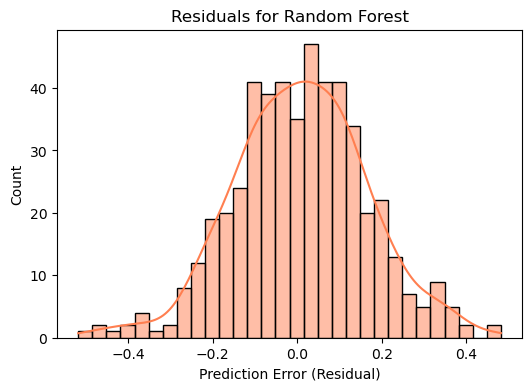

In [6]:
rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

rf_model, rf_rmse, rf_params = tune_and_evaluate(RandomForestRegressor(random_state=42), rf_param_grid, "Random Forest")


XGBoost RMSE: 0.0628, R²: 0.9860


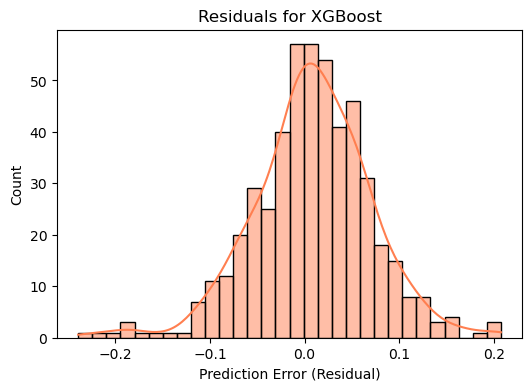

In [7]:
xgb_param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7]
}

xgb_model, xgb_rmse, xgb_params = tune_and_evaluate(XGBRegressor(random_state=42), xgb_param_grid, "XGBoost")

Lasso Regression RMSE: 0.0365, R²: 0.9953


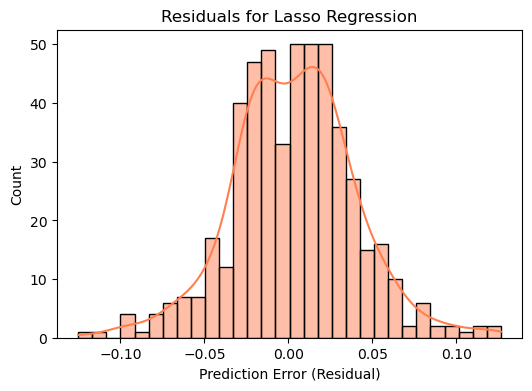

In [8]:
lasso_param_grid = {
    'alpha': [0.01, 0.1, 1.0, 10.0]
}

lasso_model, lasso_rmse, lasso_params = tune_and_evaluate(Lasso(random_state=42), lasso_param_grid, "Lasso Regression")


C:\Users\hrith\AppData\Local\Temp\ipykernel_31548\3084980858.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=rmse_results, x="Model", y="RMSE", palette="coolwarm")


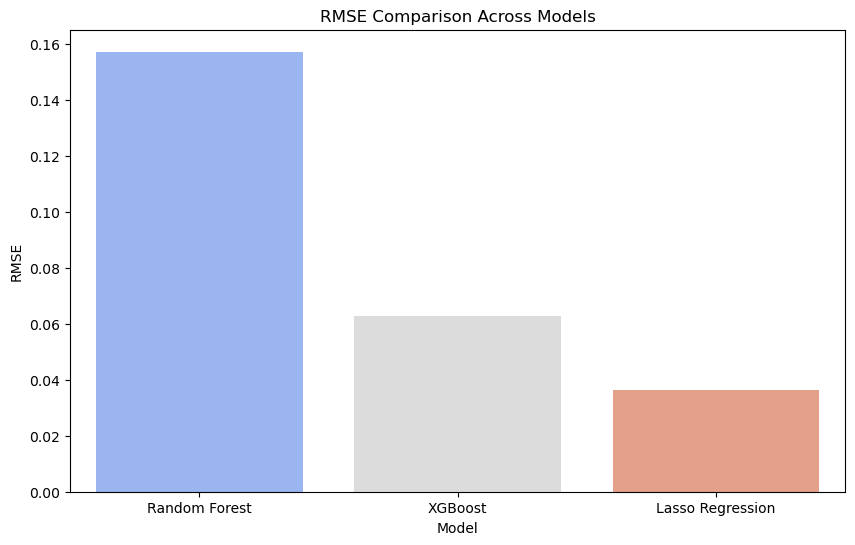

In [9]:
rmse_results = pd.DataFrame({
    "Model": ["Random Forest", "XGBoost", "Lasso Regression"],
    "RMSE": [rf_rmse, xgb_rmse, lasso_rmse]
})

plt.figure(figsize=(10, 6))
sns.barplot(data=rmse_results, x="Model", y="RMSE", palette="coolwarm")
plt.title("RMSE Comparison Across Models")
plt.ylabel("RMSE")
plt.show()

C:\Users\hrith\AppData\Local\Temp\ipykernel_31548\3282739688.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=rf_importances.index, y=rf_importances.values, palette="viridis")


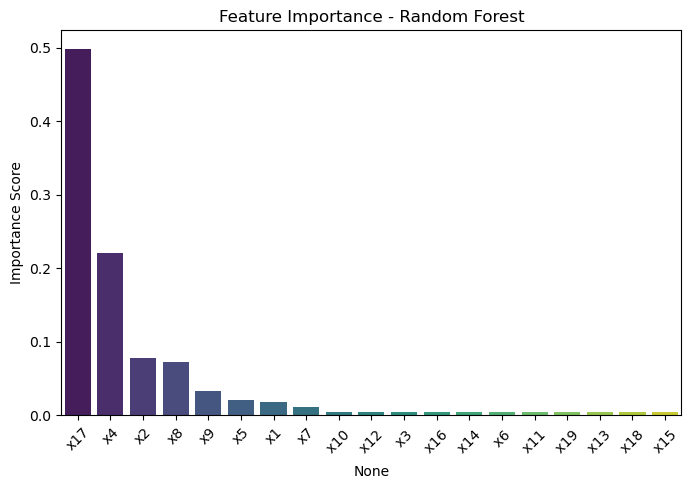

C:\Users\hrith\AppData\Local\Temp\ipykernel_31548\3282739688.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=xgb_importances.index, y=xgb_importances.values, palette="magma")


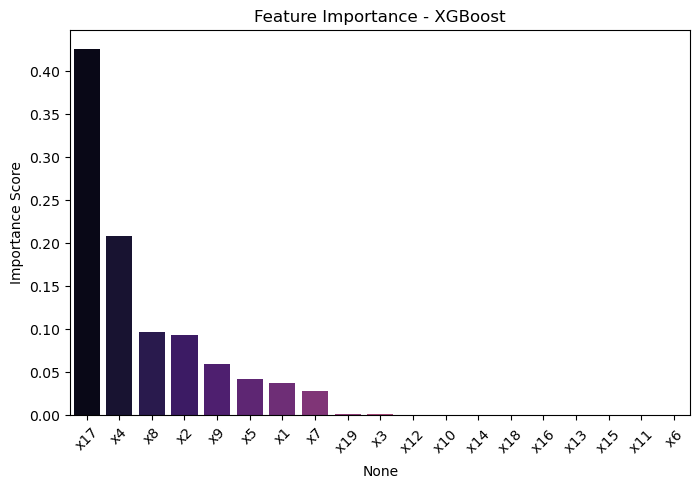

In [18]:
rf_importances = pd.Series(rf_model.feature_importances_, index=X.columns)
rf_importances = rf_importances.sort_values(ascending=False)

plt.figure(figsize=(8, 5))
sns.barplot(x=rf_importances.index, y=rf_importances.values, palette="viridis")
plt.xticks(rotation=45)
plt.title("Feature Importance - Random Forest")
plt.ylabel("Importance Score")
plt.show()

# Sort and plot XGBoost Feature Importance
xgb_importances = pd.Series(xgb_model.feature_importances_, index=X.columns)
xgb_importances = xgb_importances.sort_values(ascending=False)

plt.figure(figsize=(8, 5))
sns.barplot(x=xgb_importances.index, y=xgb_importances.values, palette="magma")
plt.xticks(rotation=45)
plt.title("Feature Importance - XGBoost")
plt.ylabel("Importance Score")
plt.show()

In [31]:
def tune_and_evaluate2(model, param_grid, name):
    # Cross-validation to find the best parameters
    search = GridSearchCV(model, param_grid, cv=kfold, scoring="neg_mean_squared_error", verbose=0)
    search.fit(X_train, y_train)
    
    best_model = search.best_estimator_
    y_pred = best_model.predict(X_test)
    
    # Error Metrics
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    print(f"{name} RMSE: {rmse:.4f}, R²: {r2:.4f}")
    

    # Actual vs Predicted Plot
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, color="teal", alpha=0.6)
    plt.plot(y_test, y_test, color="black", linestyle="--")  # Perfect prediction line
    plt.title(f"Actual vs Predicted for {name}")
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.grid()
    plt.show()
    
    return best_model, rmse, r2

In [32]:
def compare_models(model_metrics):
    # Convert metrics to DataFrame
    metrics_df = pd.DataFrame(model_metrics).T
    metrics_df.columns = ["RMSE", "R²"]
    metrics_df = metrics_df.sort_values(by="RMSE")
    
    # Bar Plot for Model Comparison
    plt.figure(figsize=(10, 6))
    metrics_df.plot(kind='bar', color=['skyblue', 'orange'])
    plt.title("Model Performance Comparison")
    plt.ylabel("Score")
    plt.xticks(rotation=45)
    plt.grid()
    plt.tight_layout()
    plt.show()

Random Forest RMSE: 0.1587, R²: 0.9107


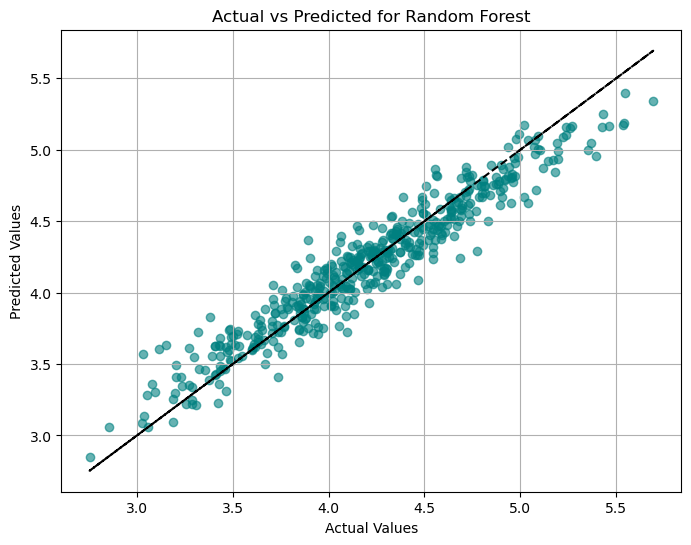

XGBoost RMSE: 0.0911, R²: 0.9706


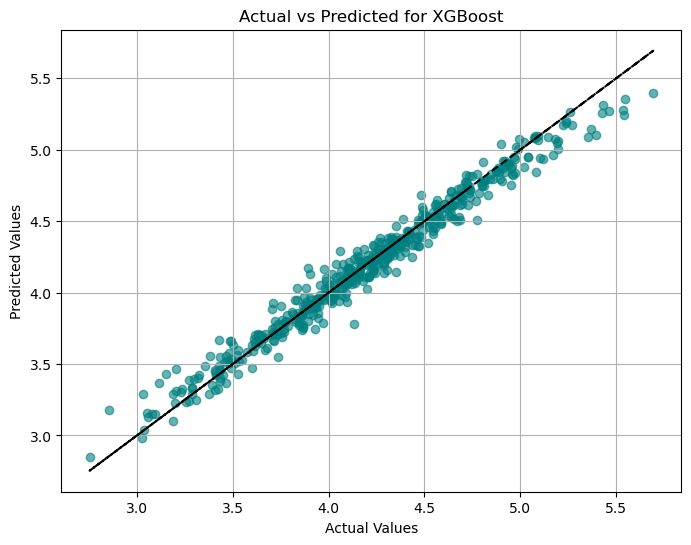

Ridge Regression RMSE: 0.0253, R²: 0.9977


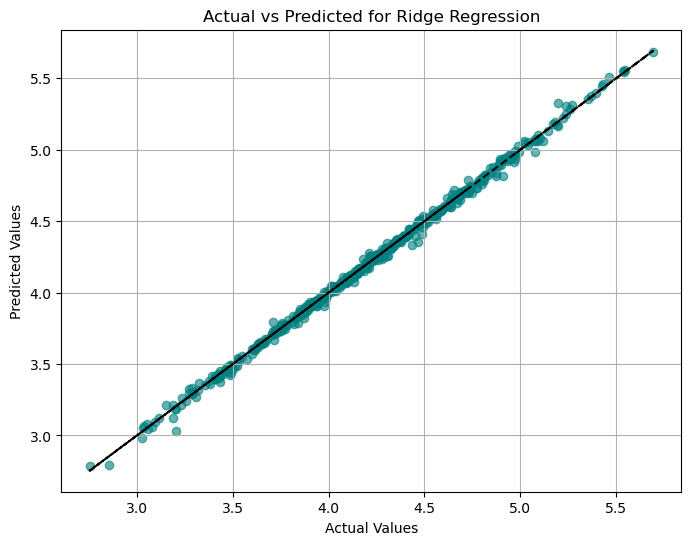

<Figure size 1000x600 with 0 Axes>

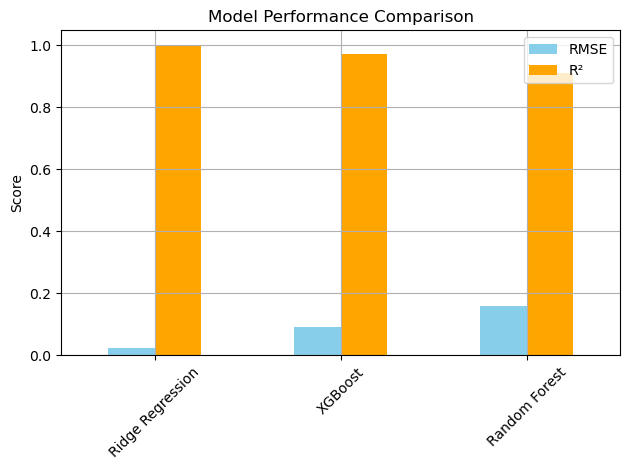

In [33]:
from sklearn.linear_model import Ridge


models = {
    "Random Forest": (RandomForestRegressor(), {"n_estimators": [50, 100], "max_depth": [None, 10]}),
    "XGBoost": (XGBRegressor(), {"n_estimators": [50, 100], "learning_rate": [0.05, 0.1]}),
    "Ridge Regression": (Ridge(), {"alpha": [0.1, 1, 10]})
}

model_metrics = {}

# Train, Evaluate and Compare
for name, (model, params) in models.items():
    best_model, rmse, r2 = tune_and_evaluate2(model, params, name)
    model_metrics[name] = [rmse, r2]

# Compare Model Performance
compare_models(model_metrics)